In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tt

from utils import CustomDataSet, load_data, print_config, DeviceDataLoader, supervised_samples, calc_mean_std, plotting, get_PATH, set_random_seed
import config

from Classifier import Classifier

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :     MNIST
NUM_LABELLED  :        -1
DEVICE        :    cuda:0
EPOCHS        :         5
BATCH_SIZE    :       512
LEARNING_RATE :    0.0002
SCHED         :     False
GAN_BATCH_SIZE:       128


In [3]:
set_random_seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "CNN"

In [5]:
PATH = get_PATH(name)
PATH

'MNIST/CNN/_full'

In [6]:
if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3
	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [7]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [8]:
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [9]:
n_classes = len(classes)
channels = train_ds.x.shape[1]
n_classes, channels

(10, 1)

In [10]:
X_sup, y_sup = supervised_samples(train_ds.x, train_ds.y, config.NUM_LABELLED, n_classes)

In [11]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)

In [12]:
train_dl = DataLoader(sup_ds, config.BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_ds, config.BATCH_SIZE, num_workers=3, pin_memory=True)

In [13]:
train_dl = DeviceDataLoader(train_dl, config.DEVICE)
valid_dl = DeviceDataLoader(valid_dl, config.DEVICE)

In [14]:
test_ds.x.shape, test_ds.y.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [15]:
model = Classifier(channels, n_classes).to(config.DEVICE, non_blocking=True)
model

Classifier(
  (conv): ConvModel(
    (initial): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (Conv): Sequential(
      (0): ConvBn(
        (Conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBn(
        (Conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): ConvBn(
        (Conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(512, eps=1e-05

In [16]:
history = model.fit(config.EPOCHS, config.LEARNING_RATE, train_dl, opt_func=optim.Adam, sched=config.SCHED, PATH=PATH+".pt", save=True)

Epoch [0]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.0530
Epoch [1]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.0240
Epoch [2]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.0126
Epoch [3]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.0128
Epoch [4]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.0035


In [20]:
model.load_state_dict(torch.load(PATH+".pt"))

<All keys matched successfully>

In [21]:
model.evaluate(valid_dl)

0.994700014591217

In [22]:
import pickle

In [23]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [24]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

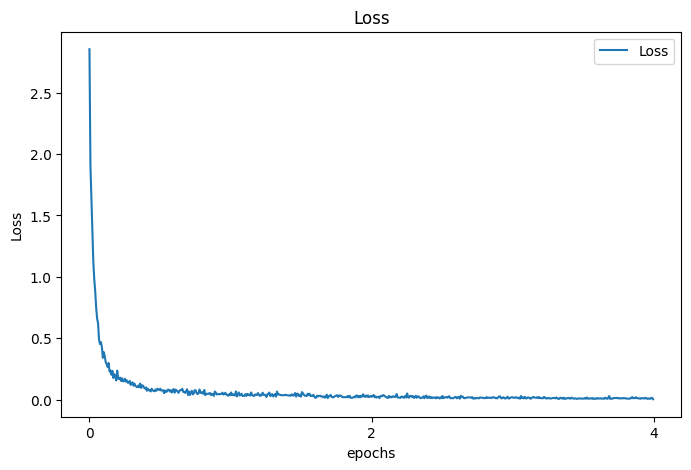

In [25]:
plotting(history)